# Notebook 03 — Model Training

**Objetivos:**
- Carregar os dados de treino e teste (já processados)
- Separar features e variável-alvo (`churnvalue`)
- Treinar um modelo baseline (Logistic Regression)
- Avaliar desempenho (Accuracy, F1, ROC-AUC)
- Guardar resultados para comparação futura


In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))

In [2]:

# --- Imports ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, confusion_matrix
)

from src.utils_data import load_df

# --- Caminhos ---
DATA_DIR = os.path.join("..", "data", "processed")


In [3]:
# 1️⃣ Carregar datasets
# ============================================================

train_df = load_df("train_df", folder="processed")
test_df = load_df("test_df", folder="processed")

print(f"Train shape: {train_df.shape}")
print(f"Test shape: {test_df.shape}")

📂 Carregado: C:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\data\processed\train_df.csv
📂 Carregado: C:\Users\sarac\rep_EDSB\EnterpriseDataScienceBootcamp_workgroup\data\processed\test_df.csv
Train shape: (5634, 50)
Test shape: (1409, 50)


In [4]:
#2️⃣ Separar features (X) e target (y)
# ============================================================

target_col = "churnvalue"

X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]

X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

In [5]:
# 3️⃣ Remover identificadores e colunas com leakage
# ============================================================

cols_to_remove = []

# Remover identificadores únicos
for col in X_train.columns:
    if "id" in col.lower():
        cols_to_remove.append(col)

# Remover colunas ligadas ao churn/status
for col in X_train.columns:
    if "churn" in col.lower() or "status" in col.lower():
        cols_to_remove.append(col)

cols_to_remove = list(set(cols_to_remove))  # remover duplicados

print(f"🔍 Colunas removidas por potencial leakage: {cols_to_remove}")

X_train = X_train.drop(columns=cols_to_remove, errors="ignore")
X_test = X_test.drop(columns=cols_to_remove, errors="ignore")

🔍 Colunas removidas por potencial leakage: ['customerstatus', 'churnreason', 'churnscore', 'churnlabel', 'churncategory', 'customerid']


In [6]:
# 4️⃣ Encoding automático + scaling
# ============================================================

cat_cols = X_train.select_dtypes(include="object").columns
num_cols = X_train.select_dtypes(exclude="object").columns

print(f"Categóricas: {len(cat_cols)} | Numéricas: {len(num_cols)}")

# One-hot encoding
X_train = pd.get_dummies(X_train, columns=cat_cols, drop_first=True)
X_test = pd.get_dummies(X_test, columns=cat_cols, drop_first=True)

# Alinhar colunas entre treino e teste
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Normalizar apenas variáveis numéricas originais
scaler = StandardScaler()
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])


Categóricas: 26 | Numéricas: 17



🔹 Treinando Logistic Regression...
Accuracy: 0.961 | F1: 0.924 | AUC: 0.992

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      1035
           1       0.96      0.89      0.92       374

    accuracy                           0.96      1409
   macro avg       0.96      0.94      0.95      1409
weighted avg       0.96      0.96      0.96      1409



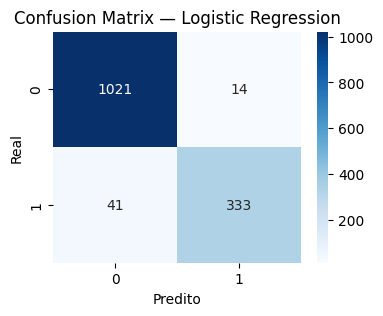


🔹 Treinando Random Forest...
Accuracy: 0.940 | F1: 0.879 | AUC: 0.969

Classification report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      1035
           1       0.95      0.82      0.88       374

    accuracy                           0.94      1409
   macro avg       0.94      0.90      0.92      1409
weighted avg       0.94      0.94      0.94      1409



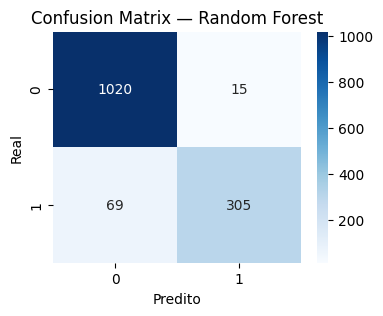

In [7]:
# 5️⃣ Treinar modelos
# ============================================================

models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
}

results = []

for name, model in models.items():
    print(f"\n🔹 Treinando {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f"Accuracy: {acc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    results.append({
        "Model": name,
        "Accuracy": acc,
        "F1-score": f1,
        "ROC-AUC": auc
    })

    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predito")
    plt.ylabel("Real")
    plt.show()


📊 Comparativo de modelos:


,Model,Accuracy,F1-score,ROC-AUC
0,Logistic Regression,0.960965,0.923717,0.991537
1,Random Forest,0.940383,0.878963,0.969402


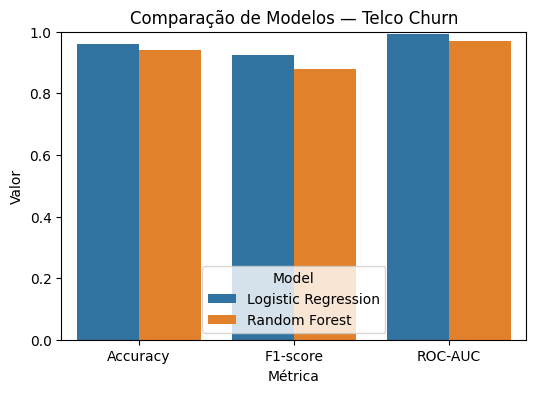

In [8]:
# 6️⃣ Comparar resultados
# ============================================================

results_df = pd.DataFrame(results).sort_values("ROC-AUC", ascending=False)
print("\n📊 Comparativo de modelos:")
display(results_df)

plt.figure(figsize=(6, 4))
sns.barplot(
    data=results_df.melt(id_vars="Model", var_name="Métrica", value_name="Valor"),
    x="Métrica", y="Valor", hue="Model"
)
plt.title("Comparação de Modelos — Telco Churn")
plt.ylim(0, 1)
plt.show()

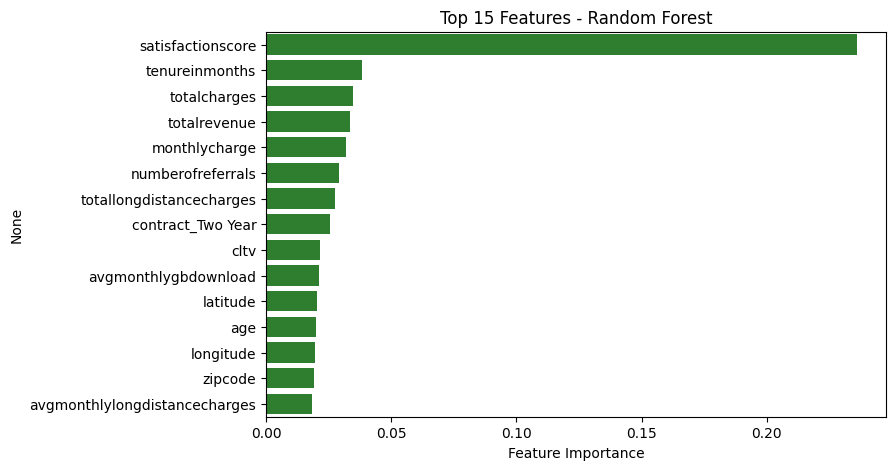

In [9]:
# 7️⃣ Importância de Features (Random Forest)
# ============================================================

rf = models["Random Forest"]
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(8, 5))
sns.barplot(x=top_features.values, y=top_features.index, color="forestgreen")
plt.title("Top 15 Features - Random Forest")
plt.xlabel("Feature Importance")
plt.show()

In [10]:
# 8️⃣ Guardar resultados
# ============================================================

results_df.to_csv(os.path.join(DATA_DIR, "model_results.csv"), index=False)
print("\n✅ Resultados guardados em data/processed/model_results.csv")


✅ Resultados guardados em data/processed/model_results.csv
